#Marketing Mix Modeling

In [4]:
# Install lightweight_mmm library
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 29.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [5]:
# Import jax.numpy and any other library we might need
import jax.numpy as jnp
import numpyro

In [6]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Organising the data for modelling

In [7]:
import pandas as pd

# Dataset
df = pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

# 1. Media variables
# Media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']

# 2. Control variables
# Holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# Seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]

control_vars =  hldy_cols + seas_cols

# 3. Sales variables
sales_cols =['sales']

df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]



In [8]:
df_main.head()

,wk_strt_dt,sales,Direct Mail,Insert,Newspaper,Radio,TV,Social Media,Online Display,hldy_Black Friday,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,72051457.64,678410.26,129759.66,507635.16,254134.14,216725.59,0.0,61364.75,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,78794770.54,661097.71,70355.33,625719.37,106602.98,108919.26,0.0,132643.90,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,70071185.56,1874338.43,107720.37,277532.61,59011.42,74032.19,0.0,76741.27,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,68642464.59,306583.37,141708.61,186028.61,178010.46,110995.66,0.0,193043.55,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,86190784.65,2366274.16,160691.30,706694.09,144097.56,225140.84,0.0,249612.89,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
SEED = 42

In [10]:
data_size = len(df_main)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

We can then split the dataset into train and test. Lets leave only the last 24 weeks for testing in this case.

In [11]:
# Split and scale data
test_data_period_size = 24
split_point = data_size - test_data_period_size

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

In most cases you will need 3 or 4 scalers. One scaler for the media data, one
for the target and one for costs. Optionally if you are adding extra features
those might need an extra scaler. **It is very important that you save and
"carry with you" those scalers throughout your MMM journey as LighweightMMM will
allow you to re-insert these scalers at different points to ensure everything is
always in the correct scale and results. If some results don't make sense, it
might be a scaling problem.**

In [12]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

### Training the model

The currently available models are the following:
- hill_adstock
- adstock
- carryover

In [13]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

Training the model will require the following mandatory parameters:
- media
- total_costs (one value per channel)
- target

We can optionally also pass the following:
- extra_features: Other variables to add to the model.
- degrees_seasonality: Number of degrees to use for seasonality. Default is 3.
- seasonality_frequency: Frequency of the time period used. Default is 52 as in 52 weeks per year.
- media_names: Names of the media channels passed.
- number_warmup: Number of warm up samples. Default is 1000.
- number_samples: Number of samples during sampling. Default is 1000.
- number_chains: Number of chains to sample. Default is 2.

In [14]:
number_warmup=1000
number_samples=1000

In [15]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names = mdsp_cols,
    seed=SEED)

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s, 1023 steps of size 1.69e-03. acc. prob=0.94]



You can check the summary of your trace by printing a summary:

In [16]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.05      0.88     -0.02     -1.43      1.39    396.80      1.00
             coef_extra_features[1]      0.02      0.71      0.00     -1.20      1.17    191.57      1.01
             coef_extra_features[2]     -0.01      0.01     -0.01     -0.03     -0.00    455.30      1.00
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01   1059.94      1.00
             coef_extra_features[4]      0.04      0.72      0.04     -1.31      1.07    204.56      1.00
             coef_extra_features[5]      0.00      0.71      0.02     -1.15      1.22    191.59      1.01
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01      0.00   1259.49      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00    931.34      1.00
             coef_extra_features[8]     -0.02

We can visualise the posterior distributions of the media effects:

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7c677e513eb0>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in fu

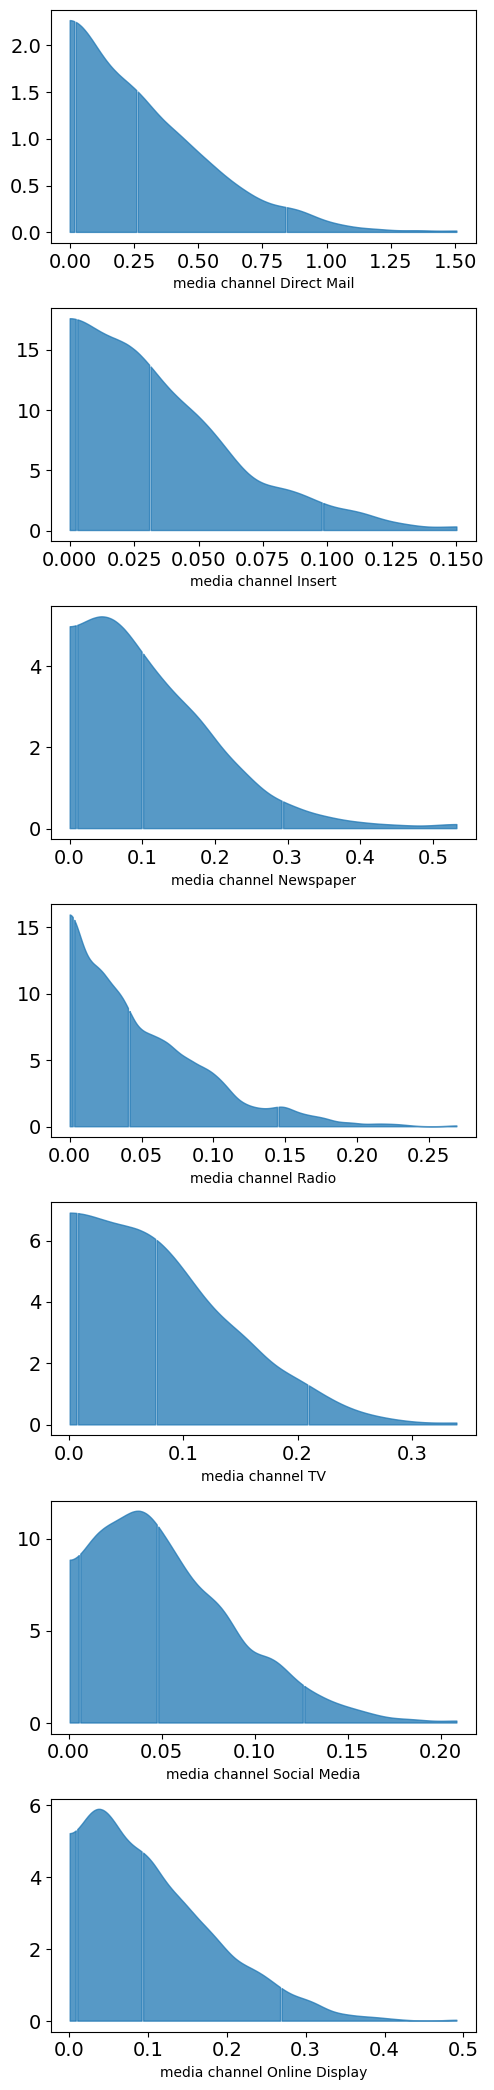

In [17]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

In [18]:
# plot.plot_prior_and_posterior(media_mix_model=mmm)

One can also check your model's fit to the training data.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


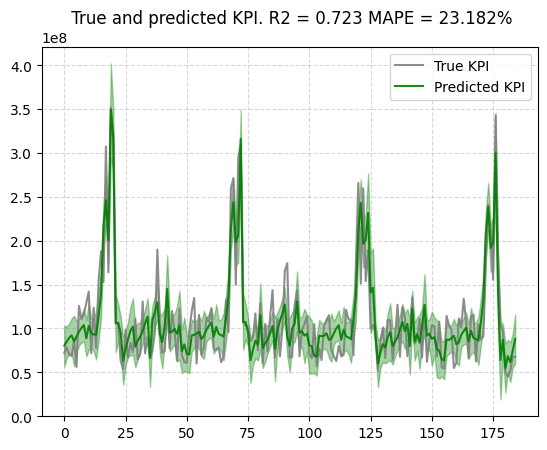

In [19]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

If one wants to run predictions on unseen data they can rely on the `predict`
method:

In [20]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)

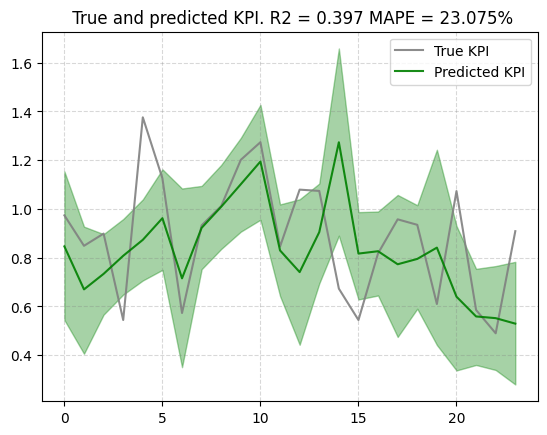

In [21]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

### Media insights

In [22]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

We can quickly visualise the estimated media & baseline contribution over time

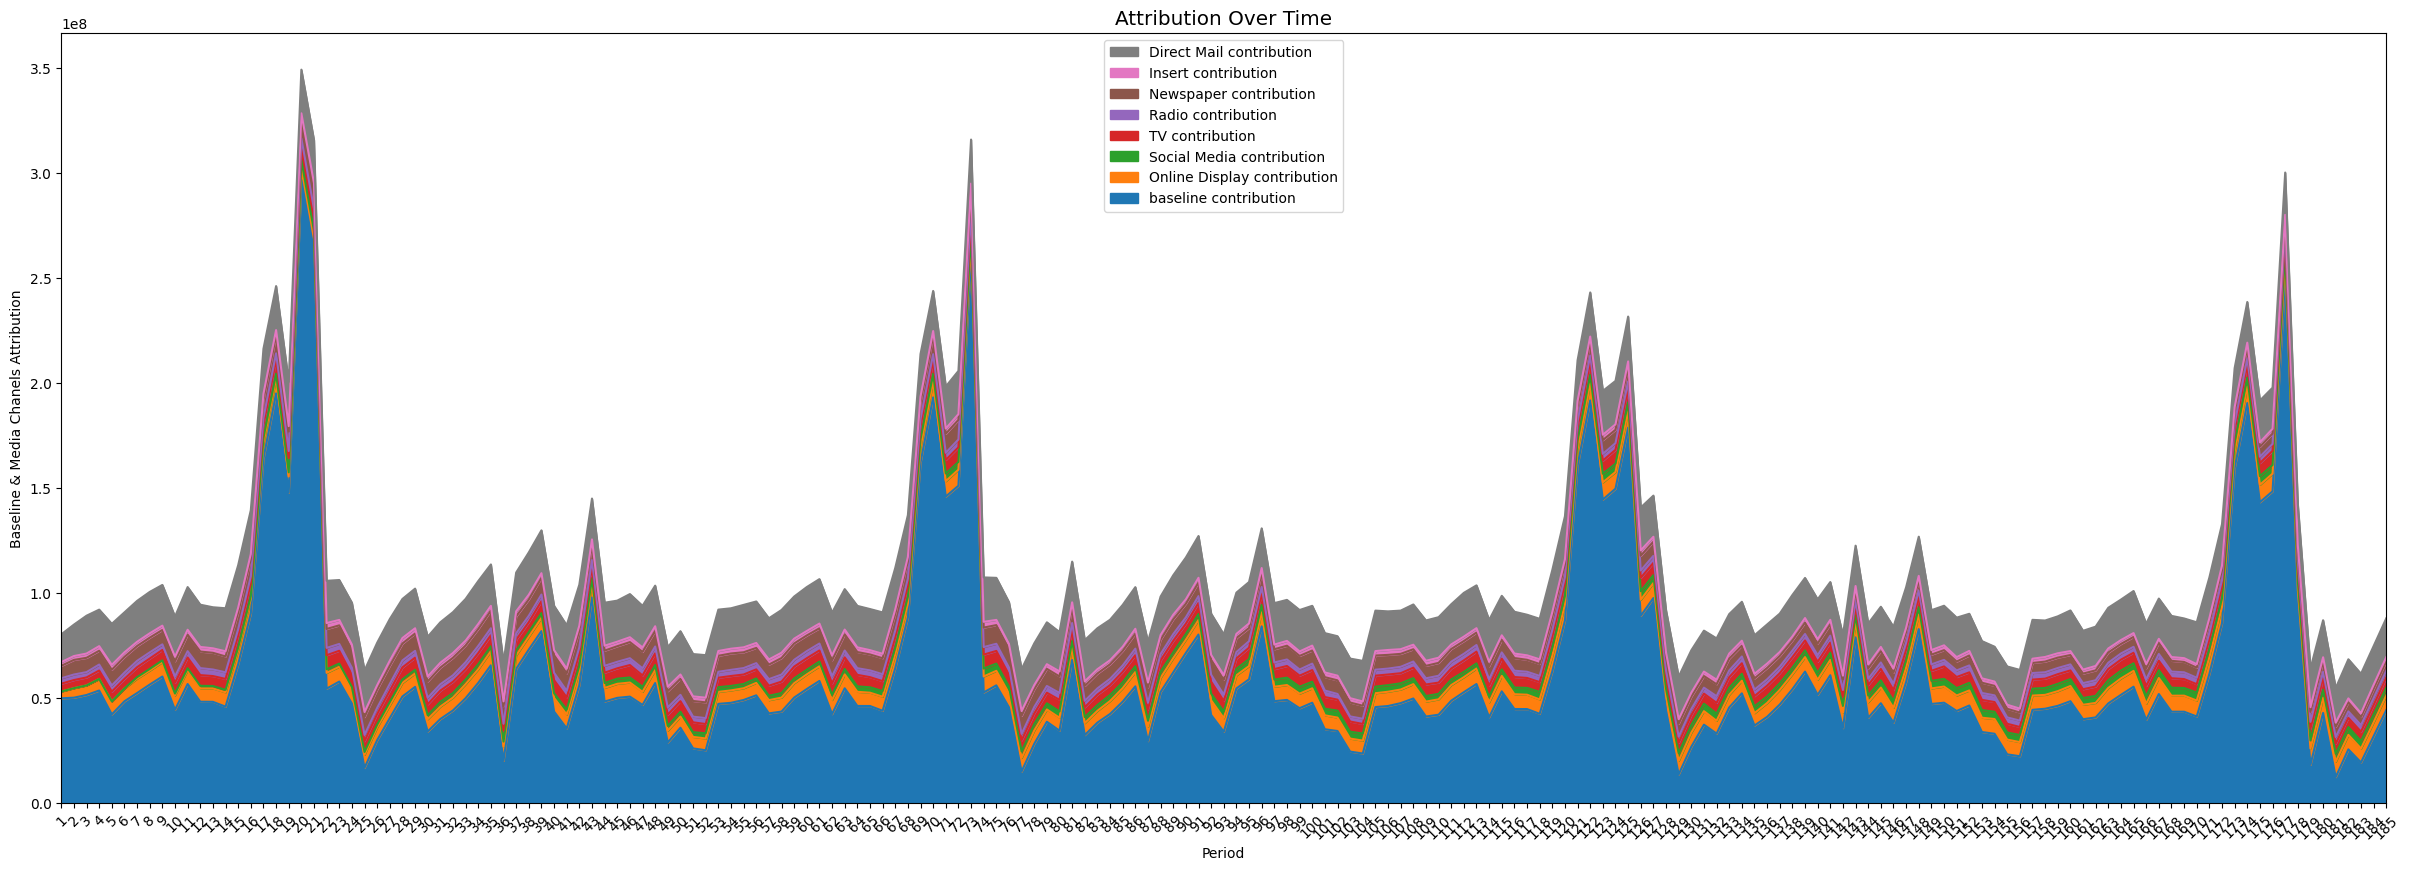

In [23]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols
                                                )


We can quickly visualise the estimated media contributions with their respective
credibility intervals

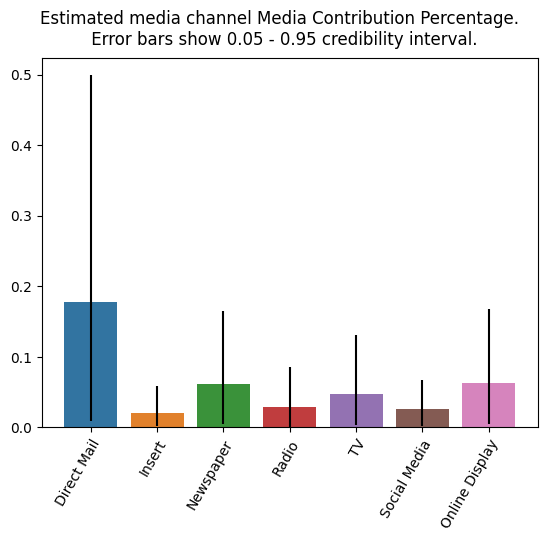

In [24]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=mdsp_cols)

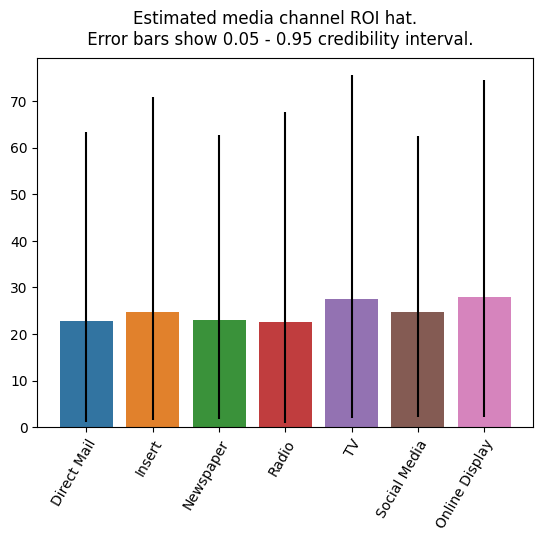

In [25]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=mdsp_cols)

Another vital question we can solve with MMMs is how each media channel behaves
individually as we invest more in it.

For that we can plot the curve response of all media channels with the following
function:

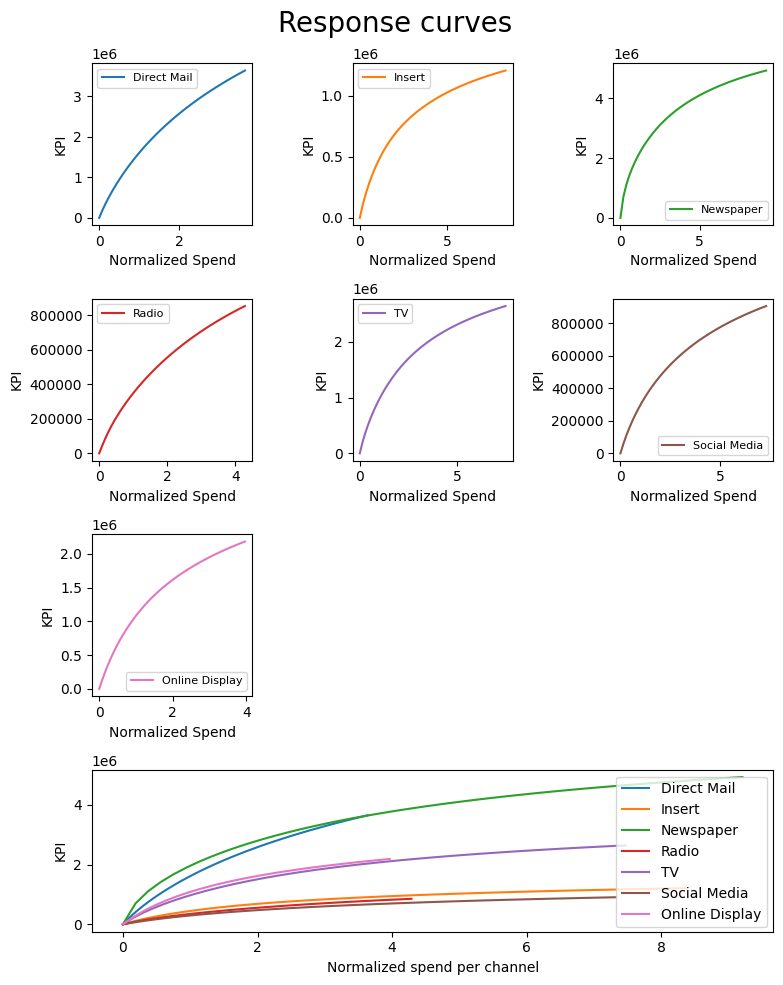

In [26]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Optimization

The optimization is meant to solve the budget allocation questions for you.
First you need to provide for how long you want to optimize your budget (eg. 15
weeks in this case).

The optimization values will be bounded by +- 20% of the max and min historic
values used for training. Which means the optimization won't recommend to
completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters: -
bounds_lower_pct - bounds_upper_pct

Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each
channel. If your data is already a money unit (eg. $) your prices should be an
array of 1s.

In [27]:
prices = jnp.ones(mmm.n_media_channels)

The budget is how much one would like to allocate throughtout the total of
`n_time_periods`. Make sure this amount is inline with the historic spend or
otherwise some conditions/bounds in the optimization might not be met.

In [28]:
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [29]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2037076695.6513443
            Iterations: 102
            Function evaluations: 1857
            Gradient evaluations: 101


If your media data is not in money unit (eg. impressions, clicks, GRPs, etc.), you would need to store the cost per values (eg. CPC) in the prices array and multiply it by solution.x to get the recommended budget allocation.



In [30]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([12732954. ,  1938811.4,  5581098.5,  2281299.5,  4242602.5,
        2253508.5,  4978613.5], dtype=float32)

In [31]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([15288896. ,  1625417.5,  5506312.5,  2342750.2,  3396159.2,
        1803910.1,  4045440.8], dtype=float32)

In [32]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(Array(34008888., dtype=float32), Array(34008888., dtype=float32))

We can double check the budget constraint was met:

In [33]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(34008888., dtype=float32), Array(34008888., dtype=float32))

## We can plot the following:
1. Pre post optimization budget allocation comparison for each channel
2. Pre post optimization predicted target variable comparison

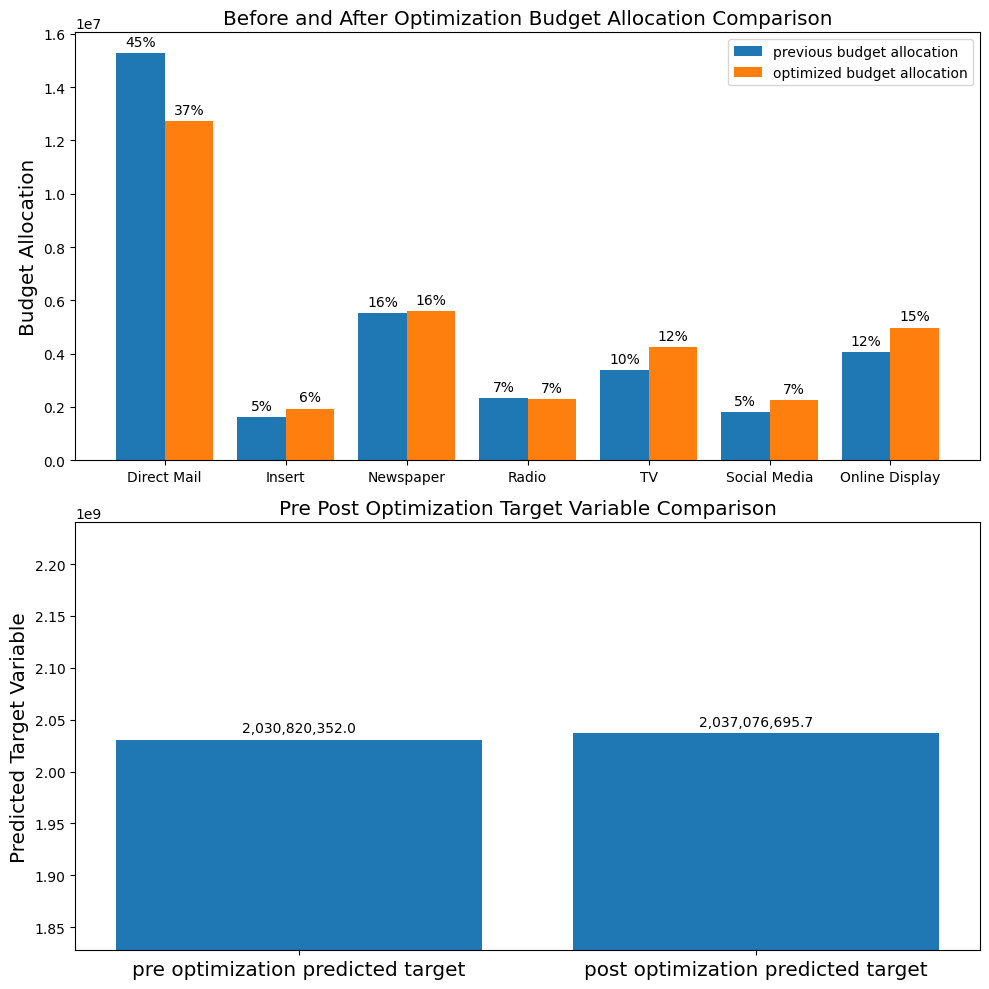

In [34]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10),
                                                channel_names = mdsp_cols)

## Saving the model to disk

In [35]:
# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

In [36]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path=file_path)
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 7)